# Лабораторная работа 2: Временные ряды

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

%matplotlib inline

### Для начала посмотрим на наш датасет. Будем исследовать объем ежемесячного производства пива в Австралии.

In [6]:
dataset = './friends.csv'
df = pd.read_csv(dataset)
dfw = df
# df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m')
# df = df.set_index(['Date'])
# df.sort_index(inplace=True)
df.head()


,user1,user2
0,1119,9216
1,1119,3580931
2,1119,6055941
3,1119,425991
4,1119,1032


Сразу сделаем разложение на сезон, тренд и остатки. 

In [7]:
df.shape

(953179, 2)

In [ ]:
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(14, 20))

decompose = seasonal_decompose(df)

ax[0].set_title('Original')
ax[1].set_title('Trend')
ax[2].set_title('Seasonal')
ax[3].set_title('Residual')

decompose.observed.plot(ax=ax[0])
dfw_trend = decompose.trend.plot(ax=ax[1])
dfw_season = decompose.seasonal.plot(ax=ax[2])
dfw_resid = decompose.resid.plot(ax=ax[3])

Сразу наблюдается положительный тренд и наличие примерно годовой сезонности. Действительно, объемы производства пива зависят от объема урожая пшеницы, который физически сезонный.  

Преобразуем массив данных под удобную для библиотеки с нашей моделью структуру.

In [ ]:
dfw["unique_id"] = "1"
dfw.columns = ["ds", "y", "unique_id"]

In [ ]:
dfw["ds"] = pd.to_datetime(dfw["ds"])
print(dfw.dtypes)
dfw.shape

In [ ]:
dfw.describe()

In [ ]:
from statsforecast import StatsForecast

StatsForecast.plot(dfw, )

In [ ]:
dfw.shape

# Посмотрим, что говорит тест Дики-Фуллера, хотя по разложению было понятно, что ряд нестационарный. 

In [ ]:
p_value = adfuller(dfw['y'])[1]
print(
    f'Полученный уровень значимости (p-value): {round(p_value, 4)}.',
    f'{round(p_value, 4)} > 0.05. Нулевая гипотеза не отвергнута в пользу альтернативной!\nРяд не стационарен'
)

# Theta model

Немного о самой модели. Вся суть заключается в разложении ряда на две составляющие, зависящие от некоторого гиперпараметра $\theta$. После обучения будет подобрано оптимальное значение $\theta$, дальше будет происходить предсказывание. Каждая из компонент, на которые мы раскладываем исходный ряд, представляется в виде: 
$$ Z_t (\theta) = \theta \cdot Y_t + (1 - \theta)\cdot(A + B\cdot t), t = 1 .. n$$
В простом случае $\theta_0 = 0$ $\theta_1 = 2$. В первом случае у нас будет линейная регрессия, которая описывает тренд. Во втором случае имеем модель, которая предсказывается с помощью экспоненциального сглаживания.
При $\theta$ < 1 линии больше влияют на долгосрочное изменение, при $\theta$ = > 1 на краткосрочные изменения временного ряда. В этом методе можно раскладывать ряд на несколько тета линий, но обычно используют только две. После нахождения этих линий, они складываются, каждая линия имеет свой вес. В обычной реализации коэффициенты A, B являются постоянными, однако существует theta модель, где эти параметры рассчитываются динамически (эту модель и будем реализовывать). В этой оптимизации обычно берут первое значение $\theta_0 = 0$, а $\theta_1 = \theta$ подбирается из перебора какого-то диапазона. Веса считаются по формуле $\frac{\theta_1 - 1}{\theta_1 - \theta_0}$, и при $\theta_0 = 0$ получаем $1 - \frac{1}{\theta_1}$. Далее уже приведены формулы расчета новых значений по предыдущим, с учетом суммы двух тета линий и с учетом их весов:

$$Y_t = \ell_{t-1} + \left( 1 - \frac{1}{\theta} \right) \left( (1 - \alpha)^{t-1} A_{t-1} + \frac{1 - (1 - \alpha)^{t}}{\alpha} B_{t-1} \right)$$


$$\ell_t = \alpha Y_t + (1 - \alpha) \ell_{t-1}$$

$$A_t = \=Y_t - \frac{t+1}{2} B_t$$

$$B_t = \frac{1}{t+1} \left( (t-2) B_{t-1} + \frac{6}{t} (Y_t - \=Y_{t-1}) \right)$$

$$\=Y_t = \frac{1}{t} \left( (t-1) \=Y_{t-1} + Y_t\right)$$

Для всех t = 1, .. ,n. Эти формулы конфигурируют модель пространства состояний с параметрами $\ell \in \mathbb{R}$, 
$\alpha \in (0, 1); \alpha \in \mathbb{R}$, $\theta \in [1; \infty)$. Еще начальное состояние: $A_0 = B_0 = B_1 = \=Y_0 = 0.0$ Параметры $\ell, \alpha, \theta$ подбираются с помощью перебора какого-то объема комбинация, для каждой из них считается сумма $(Y_i - Y_{predicted\_i})^2$, и из всех таких сумм выбирается минимальная. Соотвественно, на этапе обучения мы находим оптимальную комбинацию, дальше предсказываем с помощью тех же формул свыше. 


Вся модель описывается следующим алгоритмом:
Убираем сезонность $\rightarrow$ Раскладываем на две компоненты $Z(\theta_0)$ и  $Z(\theta_1) (обучение)$ $\rightarrow$ Экстраполируем первую компоненту линейной регрессией, вторую экспоненциальным сглаживанием (предсказание) $\rightarrow$ Складываем эти компоненты исходя из их весов (обычно они равны) $\rightarrow$ Возвращаем сезонность   
[Источник](https://www.researchgate.net/publication/294420765_Models_for_optimising_the_theta_method_and_their_relationship_to_state_space_models)


## Сначала разобьем ряд на тренировочную и тестовую часть

In [ ]:
train_size = int(0.85 * len(dfw))
dfw_train = dfw[:train_size]
dfw_test = dfw[train_size:]
print(dfw_train.shape)
print(dfw_test.shape)

In [ ]:
import seaborn as sns

sns.lineplot(dfw, x="ds", y="y", label="Train", linestyle="--")
sns.lineplot(dfw_test, x="ds", y="y", label="Test")
plt.title("Google requests")
plt.show()

# Библиотечная реализация Theta модели

In [ ]:
from statsforecast.models import Theta

In [ ]:
season_length = 48  #немного меньше года - лучше всего предсказывает
horizon = len(dfw_test)
model = Theta(season_length=season_length)

In [ ]:
lib_res = model.forecast(dfw_train['y'].to_numpy(), h=horizon)

# Собственная реализация Theta модели

In [ ]:
decompose = seasonal_decompose(dfw['y'], period=season_length)

In [ ]:
dfw_train_no_seasons = []
for i in range(len(dfw_train)):
    dfw_train_no_seasons.append(dfw_train['y'][i] - decompose.seasonal[i])

In [ ]:
dfw_test_no_seasons = []
shift = len(dfw_train)
for i in range(len(dfw_test)):
    dfw_test_no_seasons.append(dfw_test['y'][shift + i] - decompose.seasonal[i + shift])

In [ ]:
plt.plot(dfw_train['y'], color='blue')
plt.plot(dfw_train_no_seasons, color='red')

Убрали сезонность $\uparrow$

Формулы для подсчета новых значений

In [ ]:
def count_mu_t(l_prev, theta, alpha, a_prev, b_prev, t):
    multiplier = a_prev * ((1 - alpha) ** (t - 1)) + b_prev * (1 - (1 - alpha) ** t) / alpha
    return l_prev + (1 - 1 / theta) * multiplier

In [ ]:
def count_l_t(alpha, y_t, l_prev):
    return alpha * y_t + (1 - alpha) * l_prev

In [ ]:
def count_a_t(y_avg_t, b_t, t):
    return y_avg_t - b_t * (t + 1) / 2

In [ ]:
def count_b_t(y_t, y_avg_prev, b_prev, t):
    return ((t - 1) * b_prev + 6 * (y_t - y_avg_prev) / (t + 1)) / (t + 2)

In [ ]:
def count_y_avg_t(y_t, y_avg_prev, t):
    return ((t - 1) * y_avg_prev + y_t) / t

In [ ]:
# обучение на конкретном наборе гиперпараметров
def train(l_0, alpha, theta, y):
    a_list = [0.0]
    b_list = [0.0]
    y_avg_list = [0.0]
    l_list = [l_0]
    mu_list = []
    err = 0
    for t in range(1, len(y) + 1):
        mu_list.append(count_mu_t(l_list[t - 1], theta, alpha, a_list[t - 1], b_list[t - 1], t))
        l_list.append(count_l_t(alpha, y[t - 1], l_list[t - 1]))
        y_avg_list.append(count_y_avg_t(y[t - 1], y_avg_list[t - 1], t))
        b_list.append(count_b_t(y[t - 1], y_avg_list[t - 1], b_list[t - 1], t))
        a_list.append(count_a_t(y_avg_list[-1], b_list[-1], t))
    mu_list.append(count_mu_t(l_list[len(y)], theta, alpha, a_list[len(y)], b_list[len(y)], len(y)))
    mu_list.pop(0)
    for i in range(len(mu_list)):
        err += (mu_list[i] - y[i]) ** 2
    return mu_list, a_list, b_list, y_avg_list, l_list, err

In [ ]:
# создание списка комбинаций гиперпараметров для перебора
from itertools import product

alphas = []
l_arr = []
thetas = [1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0]
for i in range(1, 1200):
    l_arr.append(i / 10.0)

for i in range(0, 100):
    if i != 0 and i % 10 == 0:
        alphas.append(i / 100.0)

parameters = product(l_arr, alphas, thetas)
parameters_list = list(parameters)
len(parameters_list)

In [ ]:
# функция обучения с поиском оптимальной комбинации гиперпараметров
import tqdm

best_alpha, best_theta, best_l = 0.5, 2.0, 1.0
min_err = float("inf")

for param in tqdm.tqdm(parameters_list):
    cur_mu, cur_a, cur_b, cur_y_avg, cur_l, cur_err = train(param[0], param[1], param[2],
                                                            dfw_train_no_seasons)
    if cur_err < min_err:
        min_err = cur_err
        best_l = param[0]
        best_alpha = param[1]
        best_theta = param[2]
print(best_l, best_alpha, best_theta)

In [ ]:
# объем данных, полученный при обучении  
mu, a, b, y_avg, l, err = train(best_l, best_alpha, best_theta, dfw_train_no_seasons)

In [ ]:
# оптимальные гиперпараметры
best_l, best_alpha, best_theta

In [ ]:
# графики исходных и обученных данных
plt.plot(dfw_train_no_seasons, linewidth=3)
plt.plot(mu, color='red', linewidth=1)

In [ ]:
# функция, предсказывающая по найденным гиперпараметрам
def forecasting(level, alpha, theta, train_data, train_a, train_b, train_y_avg, horizon):
    a_list = [train_a[-1]]
    b_list = [train_b[-1]]
    y_avg_list = [train_y_avg[-1]]
    l_list = [level[-1]]
    mu_list = []
    y = [train_data[-1]]
    train_shift = len(train_data)
    for t in range(0, horizon):
        mu_list.append(count_mu_t(l_list[-1], theta, alpha, a_list[-1], b_list[-1], t + train_shift))
        l_list.append(count_l_t(alpha, y[-1], l_list[-1]))
        b_list.append(count_b_t(y[-1], y_avg_list[-1], b_list[-1], t + train_shift))
        y_avg_list.append(count_y_avg_t(y[-1], y_avg_list[-1], t + train_shift))
        a_list.append(count_a_t(y_avg_list[-1], b_list[-1], t + train_shift))
        y.append(mu_list[-1])
    mu_list.append(count_mu_t(l_list[-1], theta, alpha, a_list[-1], b_list[-1], len(y) + train_shift))
    mu_list.pop(0)
    return mu_list

In [ ]:
horizon = len(dfw_test)
predicted = forecasting(l, best_alpha, best_theta, dfw_train_no_seasons, a, b, y_avg, horizon)

In [ ]:
# функция, возвращающая сезонность
season = 48
shift_dif = (len(dfw_train) - len(dfw_test) + 1) % season
shift = (len(dfw_test) + shift_dif) % season
for i in range(0, horizon):
    predicted[i] += decompose.seasonal.iloc[(i + shift) % season]

In [ ]:
# переход обратно к временному ряду
handmade = dfw_test.copy()
handmade['y'] = predicted
library = dfw_test.copy()
library['y'] = lib_res['mean']

In [ ]:
fig, ax = plt.subplots(figsize=(14, 7))

ax.plot(handmade['ds'], handmade['y'], label="ручная", color='red')
ax.plot(library['ds'], library['y'], label="библиотека", color='yellow')
ax.plot(dfw_test['ds'], dfw_test['y'], label="исходные данные", color='blue')

ax.set_title("Графики c исходными и предсказанными данными")
plt.legend()
plt.show()


# Анализ точности методов

# MAPE 

In [ ]:
mape_lib_err = 0
mape_handmade_err = 0
between = 0
for i in range(len(lib_res['mean'])):
    mape_lib_err += abs((dfw_test['y'].to_numpy()[i] - lib_res['mean'][i]) / dfw_test['y'].to_numpy()[i])
    mape_handmade_err += abs((dfw_test['y'].to_numpy()[i] - predicted[i]) / dfw_test['y'].to_numpy()[i])
    between += abs((predicted[i] - lib_res['mean'][i]) / lib_res['mean'][i])
    
between = 100 * between / len(predicted)    
mape_lib_err = 100 * mape_lib_err / len(lib_res['mean'])
mape_handmade_err = 100 * mape_handmade_err / len(predicted)

print("MAPE")
print("library: ", mape_lib_err)
print("handmade: ", mape_handmade_err)
print("between library and handmade: ", between)

Как видно, библиотечная реализация немного точнее предсказывает.

# MSE

In [ ]:
mse_lib_err = 0
mse_handmade_err = 0
between = 0
for i in range(len(lib_res['mean'])):
    mse_lib_err += (dfw_test['y'].to_numpy()[i] - lib_res['mean'][i]) ** 2
    mse_handmade_err += (dfw_test['y'].to_numpy()[i] - predicted[i]) ** 2
mse_lib_err = mse_lib_err / len(lib_res['mean'])
mse_handmade_err = mse_handmade_err / len(predicted)
print("MSE")
print("library: ", mse_lib_err)
print("handmade: ", mse_handmade_err)

# MAE

In [ ]:
mae_lib_err = 0
mae_handmade_err = 0
for i in range(len(lib_res['mean'])):
    mae_lib_err += abs(dfw_test['y'].to_numpy()[i] - lib_res['mean'][i])
    mae_handmade_err += abs(dfw_test['y'].to_numpy()[i] - predicted[i])
mae_lib_err = mae_lib_err / len(lib_res['mean'])
mae_handmade_err = mae_handmade_err / len(predicted)
print("MAE:")
print("library: ", mae_lib_err)
print("handmade: ", mae_handmade_err)

Опять же библиотека делает немного точнее.

In [370]:
decompose = seasonal_decompose(dfw['y'], period=season_length)

In [371]:
dfw_train_no_seasons = []
for i in range(len(dfw_train)):
    dfw_train_no_seasons.append(dfw_train['y'][i] - decompose.seasonal[i])

In [372]:
dfw_test_no_seasons = []
shift = len(dfw_train)
for i in range(len(dfw_test)):
    dfw_test_no_seasons.append(dfw_test['y'][shift + i] - decompose.seasonal[i + shift])

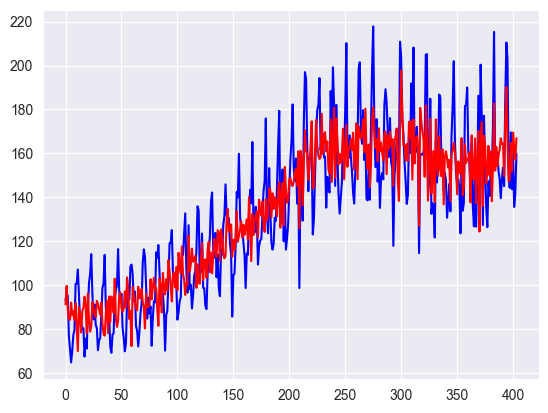

In [373]:
plt.plot(dfw_train['y'], color='blue')
plt.plot(dfw_train_no_seasons, color='red')

Убрали сезонность $\uparrow$

Формулы для подсчета новых значений

In [374]:
def count_mu_t(l_prev, theta, alpha, a_prev, b_prev, t):
    multiplier = a_prev * ((1 - alpha) ** (t - 1)) + b_prev * (1 - (1 - alpha) ** t) / alpha
    return l_prev + (1 - 1 / theta) * multiplier

In [375]:
def count_l_t(alpha, y_t, l_prev):
    return alpha * y_t + (1 - alpha) * l_prev

In [376]:
def count_a_t(y_avg_t, b_t, t):
    return y_avg_t - b_t * (t + 1) / 2

In [377]:
def count_b_t(y_t, y_avg_prev, b_prev, t):
    return ((t - 1) * b_prev + 6 * (y_t - y_avg_prev) / (t + 1)) / (t + 2)

In [378]:
def count_y_avg_t(y_t, y_avg_prev, t):
    return ((t - 1) * y_avg_prev + y_t) / t

In [379]:
# обучение на конкретном наборе гиперпараметров
def train(l_0, alpha, theta, y):
    a_list = [0.0]
    b_list = [0.0]
    y_avg_list = [0.0]
    l_list = [l_0]
    mu_list = []
    err = 0
    for t in range(1, len(y) + 1):
        mu_list.append(count_mu_t(l_list[t - 1], theta, alpha, a_list[t - 1], b_list[t - 1], t))
        l_list.append(count_l_t(alpha, y[t - 1], l_list[t - 1]))
        y_avg_list.append(count_y_avg_t(y[t - 1], y_avg_list[t - 1], t))
        b_list.append(count_b_t(y[t - 1], y_avg_list[t - 1], b_list[t - 1], t))
        a_list.append(count_a_t(y_avg_list[-1], b_list[-1], t))
    mu_list.append(count_mu_t(l_list[len(y)], theta, alpha, a_list[len(y)], b_list[len(y)], len(y)))
    mu_list.pop(0)
    for i in range(len(mu_list)):
        err += (mu_list[i] - y[i]) ** 2
    return mu_list, a_list, b_list, y_avg_list, l_list, err

In [380]:
# создание списка комбинаций гиперпараметров для перебора
from itertools import product

alphas = []
l_arr = []
thetas = [1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0]
for i in range(1, 1200):
    l_arr.append(i / 10.0)

for i in range(0, 100):
    if i != 0 and i % 10 == 0:
        alphas.append(i / 100.0)

parameters = product(l_arr, alphas, thetas)
parameters_list = list(parameters)
len(parameters_list)

107910

In [381]:
# функция обучения с поиском оптимальной комбинации гиперпараметров
import tqdm

best_alpha, best_theta, best_l = 0.5, 2.0, 1.0
min_err = float("inf")

for param in tqdm.tqdm(parameters_list):
    cur_mu, cur_a, cur_b, cur_y_avg, cur_l, cur_err = train(param[0], param[1], param[2],
                                                            dfw_train_no_seasons)
    if cur_err < min_err:
        min_err = cur_err
        best_l = param[0]
        best_alpha = param[1]
        best_theta = param[2]
print(best_l, best_alpha, best_theta)

100%|██████████| 107910/107910 [02:47<00:00, 645.13it/s]

0.1 0.9 1.1


In [382]:
# объем данных, полученный при обучении  
mu, a, b, y_avg, l, err = train(best_l, best_alpha, best_theta, dfw_train_no_seasons)

In [383]:
# оптимальные гиперпараметры
best_l, best_alpha, best_theta

(0.1, 0.9, 1.1)

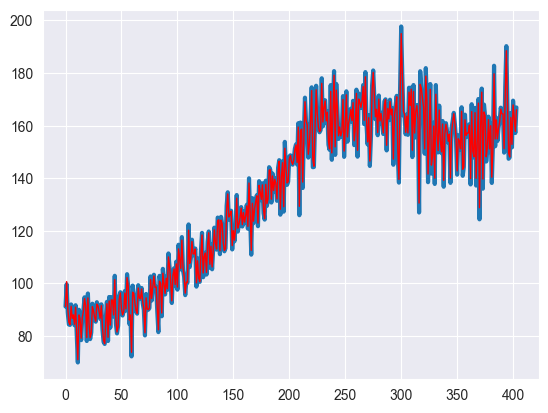

In [384]:
# графики исходных и обученных данных
plt.plot(dfw_train_no_seasons, linewidth=3)
plt.plot(mu, color='red', linewidth=1)

In [385]:
# функция, предсказывающая по найденным гиперпараметрам
def forecasting(level, alpha, theta, train_data, train_a, train_b, train_y_avg, horizon):
    a_list = [train_a[-1]]
    b_list = [train_b[-1]]
    y_avg_list = [train_y_avg[-1]]
    l_list = [level[-1]]
    mu_list = []
    y = [train_data[-1]]
    train_shift = len(train_data)
    for t in range(0, horizon):
        mu_list.append(count_mu_t(l_list[-1], theta, alpha, a_list[-1], b_list[-1], t + train_shift))
        l_list.append(count_l_t(alpha, y[-1], l_list[-1]))
        b_list.append(count_b_t(y[-1], y_avg_list[-1], b_list[-1], t + train_shift))
        y_avg_list.append(count_y_avg_t(y[-1], y_avg_list[-1], t + train_shift))
        a_list.append(count_a_t(y_avg_list[-1], b_list[-1], t + train_shift))
        y.append(mu_list[-1])
    mu_list.append(count_mu_t(l_list[-1], theta, alpha, a_list[-1], b_list[-1], len(y) + train_shift))
    mu_list.pop(0)
    return mu_list

In [386]:
horizon = len(dfw_test)
predicted = forecasting(l, best_alpha, best_theta, dfw_train_no_seasons, a, b, y_avg, horizon)

In [387]:
# функция, возвращающая сезонность
season = 48
shift_dif = (len(dfw_train) - len(dfw_test) + 1) % season
shift = (len(dfw_test) + shift_dif) % season
for i in range(0, horizon):
    predicted[i] += decompose.seasonal.iloc[(i + shift) % season]

In [388]:
# переход обратно к временному ряду
handmade = dfw_test.copy()
handmade['y'] = predicted
library = dfw_test.copy()
library['y'] = lib_res['mean']

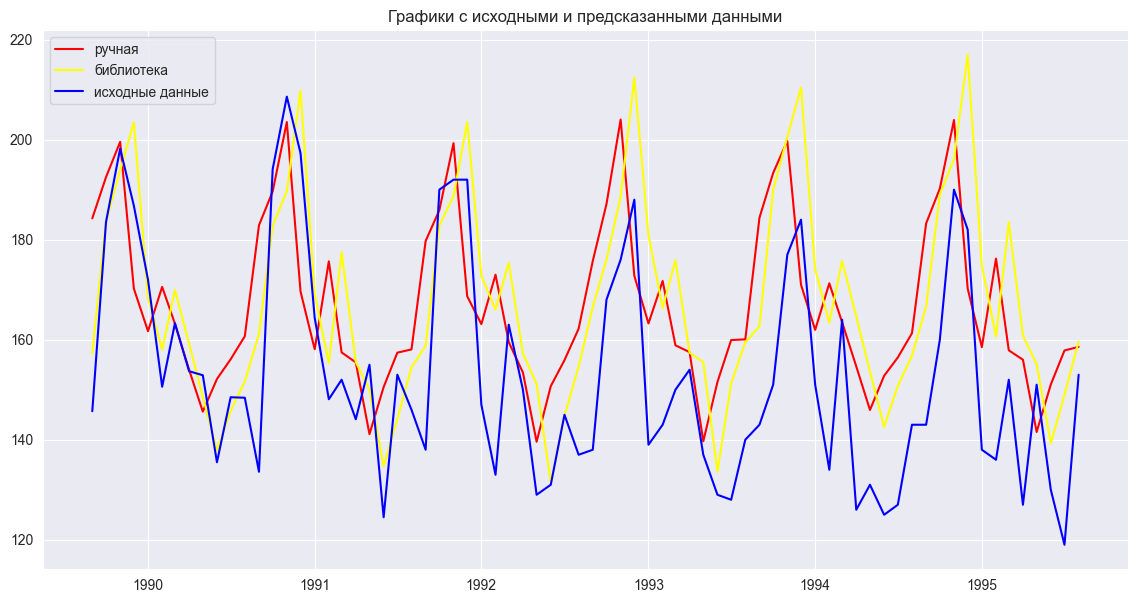

In [389]:
fig, ax = plt.subplots(figsize=(14, 7))

ax.plot(handmade['ds'], handmade['y'], label="ручная", color='red')
ax.plot(library['ds'], library['y'], label="библиотека", color='yellow')
ax.plot(dfw_test['ds'], dfw_test['y'], label="исходные данные", color='blue')

ax.set_title("Графики c исходными и предсказанными данными")
plt.legend()
plt.show()


# Анализ точности методов

# MAPE 

In [390]:
mape_lib_err = 0
mape_handmade_err = 0
between = 0
for i in range(len(lib_res['mean'])):
    mape_lib_err += abs((dfw_test['y'].to_numpy()[i] - lib_res['mean'][i]) / dfw_test['y'].to_numpy()[i])
    mape_handmade_err += abs((dfw_test['y'].to_numpy()[i] - predicted[i]) / dfw_test['y'].to_numpy()[i])
    between += abs((predicted[i] - lib_res['mean'][i]) / lib_res['mean'][i])
    
between = 100 * between / len(predicted)    
mape_lib_err = 100 * mape_lib_err / len(lib_res['mean'])
mape_handmade_err = 100 * mape_handmade_err / len(predicted)

print("MAPE")
print("library: ", mape_lib_err)
print("handmade: ", mape_handmade_err)
print("between library and handmade: ", between)

MAPE
library:  11.151788481848365
handmade:  12.87533386552408
between library and handmade:  7.617862484801078


Как видно, библиотечная реализация немного точнее предсказывает.

# MSE

In [391]:
mse_lib_err = 0
mse_handmade_err = 0
between = 0
for i in range(len(lib_res['mean'])):
    mse_lib_err += (dfw_test['y'].to_numpy()[i] - lib_res['mean'][i]) ** 2
    mse_handmade_err += (dfw_test['y'].to_numpy()[i] - predicted[i]) ** 2
mse_lib_err = mse_lib_err / len(lib_res['mean'])
mse_handmade_err = mse_handmade_err / len(predicted)
print("MSE")
print("library: ", mse_lib_err)
print("handmade: ", mse_handmade_err)

MSE
library:  389.0094689393988
handmade:  506.0702780180252


# MAE

In [392]:
mae_lib_err = 0
mae_handmade_err = 0
for i in range(len(lib_res['mean'])):
    mae_lib_err += abs(dfw_test['y'].to_numpy()[i] - lib_res['mean'][i])
    mae_handmade_err += abs(dfw_test['y'].to_numpy()[i] - predicted[i])
mae_lib_err = mae_lib_err / len(lib_res['mean'])
mae_handmade_err = mae_handmade_err / len(predicted)
print("MAE:")
print("library: ", mae_lib_err)
print("handmade: ", mae_handmade_err)

MAE:
library:  16.3282339310769
handmade:  18.55868460517093


Опять же библиотека делает немного точнее.